In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler

### **Dataset**

Imagina que eres un experto en vinos y quieres identificar el origen de un vino (el viñedo) solo conociendo sus propiedades químicas. Este es precisamente el problema que resuelve este dataset.

El conjunto de datos wine contiene los resultados de un análisis químico de tres tipos de vino diferentes, cultivados en la misma región de Italia. Cada uno de los tres tipos de vino representa una clase, que corresponde a uno de los tres viñedos.

Tu objetivo principal, al trabajar con este dataset, es construir un modelo de aprendizaje automático que pueda predecir a qué viñedo pertenece un vino basándose en su composición química. Es un problema ideal para practicar algoritmos de clasificación, ya que las clases están bien definidas y las variables son numéricas.

In [2]:
# Sección 1: Importación de librerías y carga del dataset
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Mostrar las primeras filas
X.shape

(178, 13)

En esta primera parte cargamos el dataset de vinos incluido en sklearn.
Cada fila representa un tipo de vino y las columnas son características químicas (por ejemplo, contenido de alcohol, magnesio, fenoles, etc.).

Este dataset es ideal porque tiene muchas variables correlacionadas: algunas miden propiedades químicas similares, por lo que PCA puede reducir la dimensionalidad sin perder demasiada información.

In [3]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


### **Descripción de las Variables**

El dataset se compone de 13 variables predictoras (las características químicas del vino) y una variable objetivo (la clase de vino o viñedo).

Variables Predictoras (Características Físico-Químicas):

- alcohol: Nivel de alcohol en el vino.

- malic_acid: Cantidad de ácido málico presente.

- ash: Cantidad de ceniza resultante después de la quema.

- alcalinity_of_ash: Alcalinidad de la ceniza (proporción de bases).

- magnesium: Cantidad de magnesio.

- total_phenols: Fenoles totales, un compuesto químico que influye en el sabor.

- flavanoids: Flavonoides, un tipo de fenol.

- nonflavanoid_phenols: Fenoles no flavonoides.

- proanthocyanins: Proantocianinas.

- color_intensity: Intensidad del color.

- hue: Matiz, o la pureza del color.

- od280/od315_of_diluted_wines: Medida de la absorbancia de la proteína del vino, que se utiliza para evaluar la calidad.

- proline: Cantidad de prolina, un aminoácido.

### **Variable Objetivo**

- target: La clase de vino, que representa el viñedo del cual provino la muestra. Esta variable tiene tres valores posibles: 0, 1 y 2, correspondientes a cada uno de los tres viñedos.

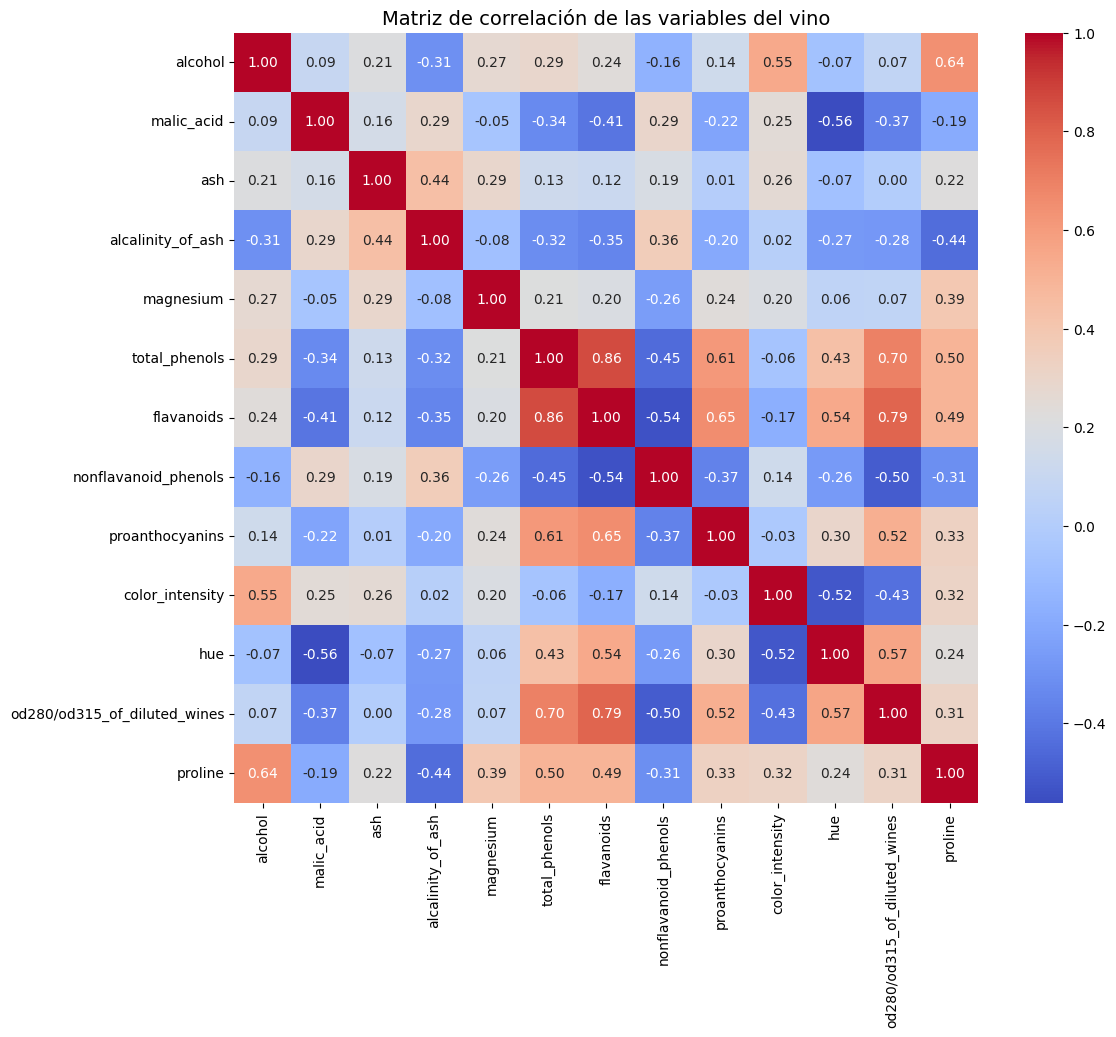

In [4]:
# Sección 2: Visualización de la matriz de correlación

plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación de las variables del vino", fontsize=14)
plt.show()

**Matriz de correlación:** para detectar relaciones lineales entre variables.
Si dos variables están muy correlacionadas (valores cercanos a 1 o -1), aportan información redundante.

Por ejemplo, en el dataset del vino, el contenido de fenoles totales y flavonoides suelen estar muy correlacionados.
Esto sugiere que podríamos representar ambas variables con una combinación lineal sin perder información relevante — justo lo que hace PCA.

In [5]:
# Sección 3: Escalado de los datos

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a DataFrame para mantener nombres de columnas
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


Antes de aplicar PCA, es esencial **estandarizar las variables**.
PCA se basa en la varianza, y si las variables están en distintas escalas (por ejemplo, “alcohol” en % y “magnesio” en mg), las de mayor magnitud dominarán el análisis.

Con StandardScaler() todas las variables pasan a tener media 0 y desviación típica 1, equilibrando su influencia en la reducción de dimensiones.

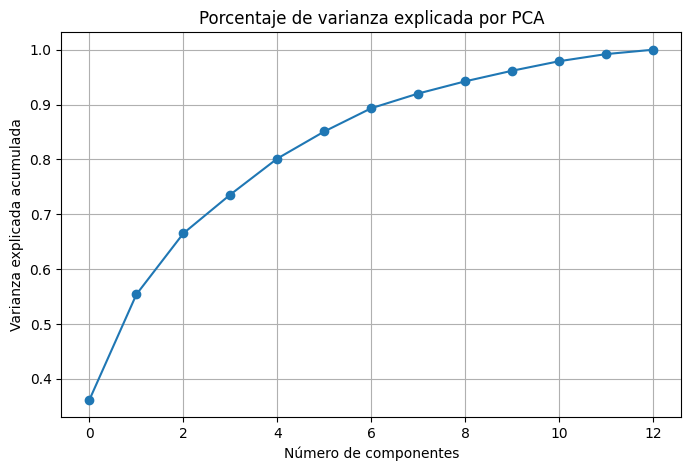

In [6]:
# Sección 4: Aplicar PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Mostrar varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Porcentaje de varianza explicada por PCA')
plt.grid(True)
plt.show()

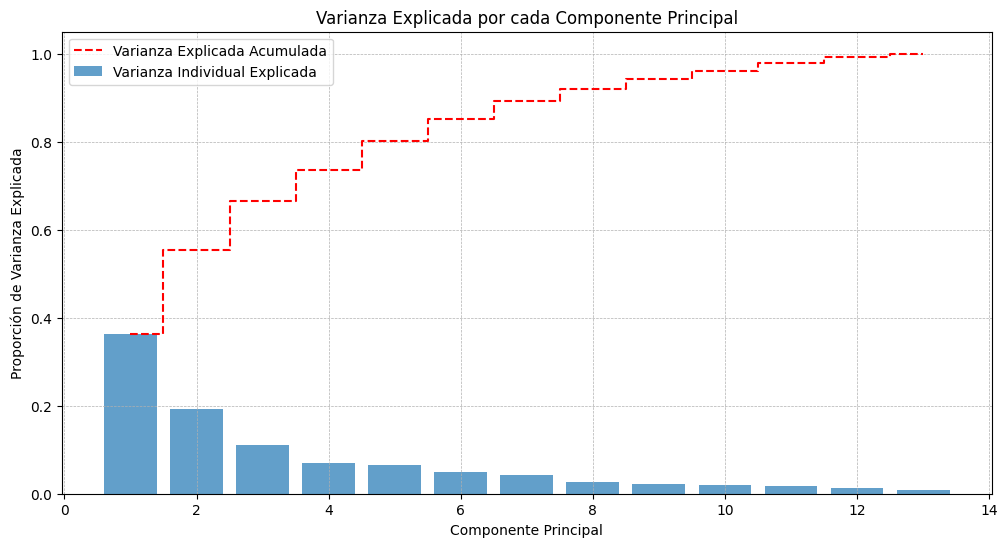

In [7]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Varianza Individual Explicada')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Varianza Explicada Acumulada', linestyle='--', color='red')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por cada Componente Principal')
plt.legend(loc='best')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

**Análisis de Componentes Principales (PCA):** para transformar las variables originales en nuevas dimensiones llamadas componentes principales.

El gráfico muestra cuánta varianza total del dataset se conserva al usar un número determinado de componentes.

Por ejemplo, si las cinco primeras componentes explican más del 80% de la varianza, podríamos reducir el dataset original de 13 variables a solo 5 dimensiones, manteniendo casi toda la información relevante.

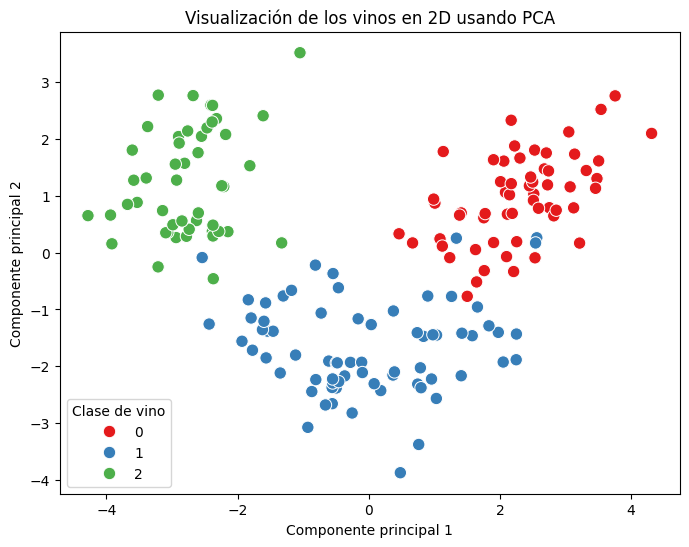

In [8]:
# Sección 5: Visualización del PCA en 2D

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=y, palette='Set1', s=80)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Visualización de los vinos en 2D usando PCA')
plt.legend(title='Clase de vino')
plt.show()

En este gráfico representamos el dataset reducido a dos componentes principales.
Cada punto es un vino, y el color representa su clase (tipo de vino).

Aunque PCA no usa las etiquetas, observamos que las clases se separan parcialmente — lo que demuestra que estas dos nuevas dimensiones capturan gran parte de la estructura original del dataset.

Este tipo de visualización permite entender la forma del espacio de datos y comprobar si existe una estructura natural de separación entre clases o grupos.

In [9]:
# Sección 6: Elementos de los componentes principales

pca_full = PCA(n_components=X.shape[1])
pca_full.fit(X_scaled)

componentes = pd.DataFrame(
    pca_full.components_,
    columns=X.columns,
    index=[f'PC{i+1}' for i in range(X.shape[1])]
)

componentes

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
PC1,0.144329,-0.245188,-0.002051,-0.239320,0.141992,0.394661,0.422934,-0.298533,0.313429,-0.088617,0.296715,0.376167,0.286752
PC2,0.483652,0.224931,0.316069,-0.010591,0.299634,0.065040,-0.003360,0.028779,0.039302,0.529996,-0.279235,-0.164496,0.364903
PC3,-0.207383,0.089013,0.626224,0.612080,0.130757,0.146179,0.150682,0.170368,0.149454,-0.137306,0.085222,0.166005,-0.126746
PC4,-0.017856,0.536890,-0.214176,0.060859,-0.351797,0.198068,0.152295,-0.203301,0.399057,0.065926,-0.427771,0.184121,-0.232071
PC5,-0.265664,0.035214,-0.143025,0.066103,0.727049,-0.149318,-0.109026,-0.500703,0.136860,-0.076437,-0.173615,-0.101161,-0.157869
PC6,0.213539,0.536814,0.154475,-0.100825,0.038144,-0.084122,-0.018920,-0.258594,-0.533795,-0.418644,0.105983,0.265851,0.119726
PC7,-0.056396,0.420524,-0.149171,-0.286969,0.322883,-0.027925,-0.060685,0.595447,0.372139,-0.227712,0.232076,-0.044764,0.076805
PC8,0.396139,0.065827,-0.170260,0.427970,-0.156361,-0.405934,-0.187245,-0.233285,0.368227,-0.033797,0.436624,-0.078108,0.120023
PC9,-0.508619,0.075283,0.307694,-0.200449,-0.271403,-0.286035,-0.049578,-0.195501,0.209145,-0.056218,-0.085828,-0.137227,0.575786
PC10,0.211605,-0.309080,-0.027125,0.052799,0.067870,-0.320131,-0.163151,0.215535,0.134184,-0.290775,-0.522399,0.523706,0.162116


Esta tabla muestra cuánto contribuye cada variable original a cada componente principal.

Por ejemplo, si la PC1 tiene cargas altas en “flavonoides”, “fenoles totales” y “od280/od315_of_diluted_wines”, significa que resume la variación conjunta de esas variables.

Analizar estas cargas ayuda a interpretar las dimensiones nuevas y entender qué tipo de información está concentrando cada componente.


### PCA
 - Reduce la dimensionalidad combinando variables correlacionadas en nuevas dimensiones que capturan la mayor varianza posible.

- Permite simplificar, visualizar y acelerar el análisis sin perder demasiada información.

- Sin embargo, las nuevas dimensiones no siempre son fácilmente interpretables, por lo que es una técnica más útil para exploración y preprocesamiento que para explicación directa.

# CLASIFICACIÓN CON PCA

In [16]:
# 1. Nos quedamos con las 5 primeras componentes principales
X_pca_5 = X_pca[:, :5]

Nos quedamos solo con las cinco primeras componentes principales, que concentran la mayor parte de la varianza del conjunto de datos. Esto simplifica los datos sin perder demasiada información.

In [20]:
# 2. Aplicamos K-Means con 3 clusters (porque el dataset tiene 3 tipos de vino)
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca_5)
y_true = y  # etiquetas reales del dataset del vino

El algoritmo K-Means busca agrupar las muestras en 3 clusters, que deberían aproximarse a las 3 variedades reales de vino del dataset.
Aquí el PCA nos ayuda: al eliminar ruido y redundancia, los clusters tienden a ser más compactos y separados.

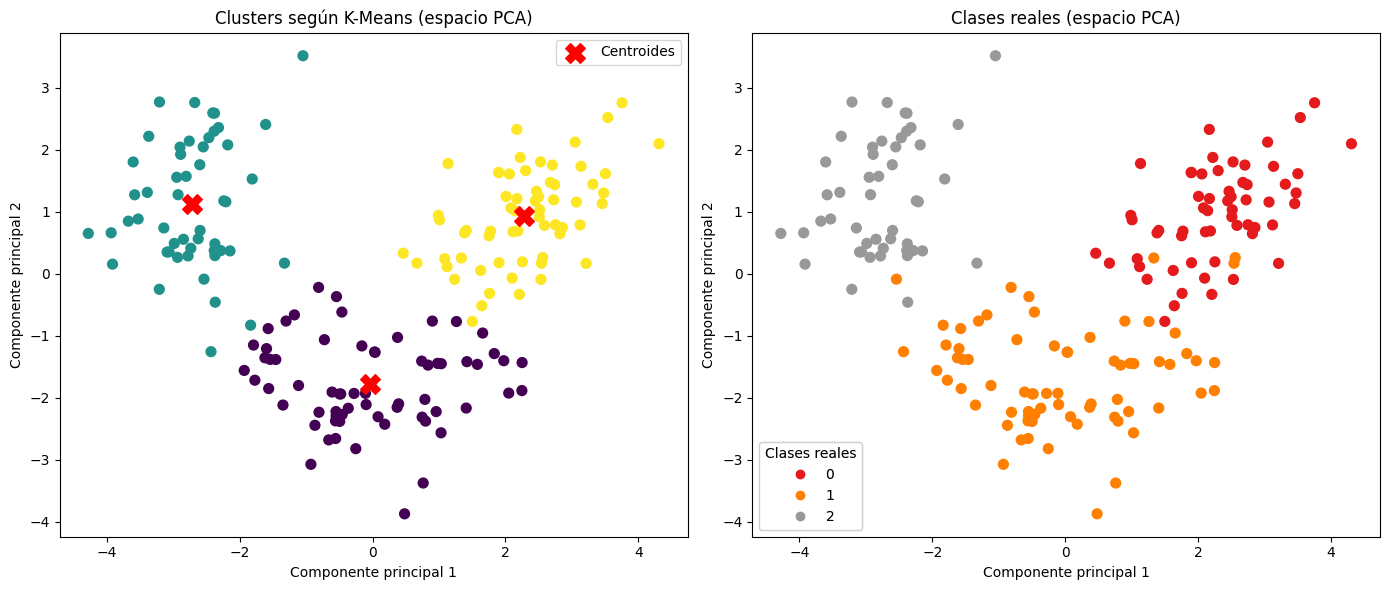

In [21]:
# Visualización comparativa: predicción vs clases reales
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# (a) Clusters según K-Means en el espacio PCA
scatter1 = axes[0].scatter(X_pca_5[:,0], X_pca_5[:,1], c=y_kmeans, cmap="viridis", s=50)
centers = kmeans.cluster_centers_
axes[0].scatter(centers[:,0], centers[:,1], c="red", s=200, marker="X", label="Centroides")
axes[0].set_title("Clusters según K-Means (espacio PCA)")
axes[0].set_xlabel("Componente principal 1")
axes[0].set_ylabel("Componente principal 2")
axes[0].legend()

# (b) Clases reales en el mismo espacio PCA
scatter2 = axes[1].scatter(X_pca_5[:,0], X_pca_5[:,1], c=y_true, cmap="Set1", s=50)
legend2 = axes[1].legend(*scatter2.legend_elements(), title="Clases reales")
axes[1].add_artist(legend2)
axes[1].set_title("Clases reales (espacio PCA)")
axes[1].set_xlabel("Componente principal 1")
axes[1].set_ylabel("Componente principal 2")

plt.tight_layout()
plt.show()

El gráfico muestra cómo las muestras se distribuyen en el espacio reducido. Los centroides (en rojo) son los puntos medios de cada grupo según K-Means.
Si las clases naturales del dataset son distintas entre sí, deberían verse como nubes de puntos bien separadas.

In [22]:
# Métricas de evaluación
print("--- Métricas de Evaluación del Modelo con PCA ---")
print(f"Silhouette Score: {silhouette_score(X_pca_5, y_kmeans):.3f}")
print(f"Adjusted Rand Index: {adjusted_rand_score(y_true, y_kmeans):.3f}")
print(f"Homogeneity: {homogeneity_score(y_true, y_kmeans):.3f}")
print(f"Completeness: {completeness_score(y_true, y_kmeans):.3f}")
print(f"V-Measure: {v_measure_score(y_true, y_kmeans):.3f}")

--- Métricas de Evaluación del Modelo con PCA ---
Silhouette Score: 0.369
Adjusted Rand Index: 0.897
Homogeneity: 0.879
Completeness: 0.873
V-Measure: 0.876


# CLASIFICACIÓN SIN PCA

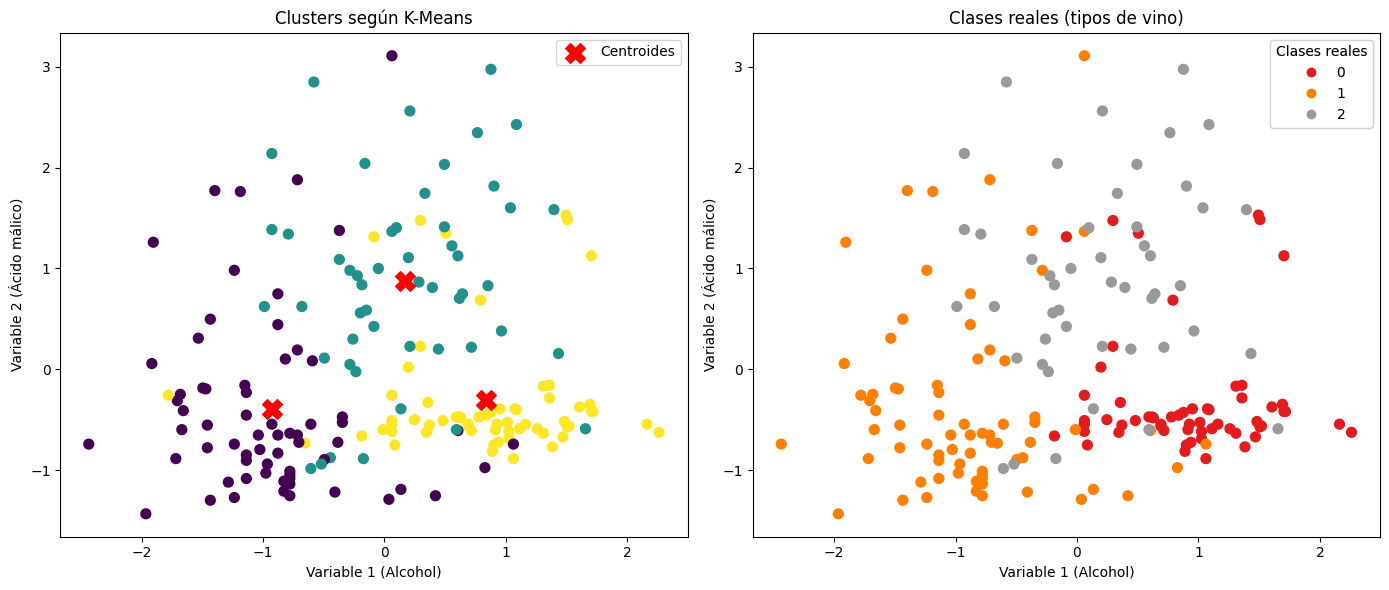

--- Métricas de Evaluación del Modelo sin PCA ---
Silhouette Score: 0.2848589191898987
Adjusted Rand Index: 0.8974949815093207
Homogeneity: 0.8788432003662366
Completeness: 0.8729636016078731
V-Measure: 0.875893534122307


In [14]:
# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_true = y  # etiquetas reales del dataset del vino

# Aplicar K-Means con 3 clusters (3 tipos de vino)
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Visualización comparativa: predicciones vs clases reales
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# (a) Clusters según K-Means
scatter1 = axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, cmap="viridis", s=50)
centers = kmeans.cluster_centers_
axes[0].scatter(centers[:, 0], centers[:, 1], c="red", s=200, marker="X", label="Centroides")
axes[0].set_title("Clusters según K-Means")
axes[0].set_xlabel("Variable 1 (Alcohol)")
axes[0].set_ylabel("Variable 2 (Ácido málico)")
axes[0].legend()

# (b) Clases reales
scatter2 = axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_true, cmap="Set1", s=50)
legend2 = axes[1].legend(*scatter2.legend_elements(), title="Clases reales")
axes[1].add_artist(legend2)
axes[1].set_title("Clases reales (tipos de vino)")
axes[1].set_xlabel("Variable 1 (Alcohol)")
axes[1].set_ylabel("Variable 2 (Ácido málico)")

plt.tight_layout()
plt.show()

# Métricas de evaluación
print("--- Métricas de Evaluación del Modelo sin PCA ---")
print("Silhouette Score:", silhouette_score(X_scaled, y_kmeans))
print("Adjusted Rand Index:", adjusted_rand_score(y_true, y_kmeans))
print("Homogeneity:", homogeneity_score(y_true, y_kmeans))
print("Completeness:", completeness_score(y_true, y_kmeans))
print("V-Measure:", v_measure_score(y_true, y_kmeans))

### **Conclusión**

**Interpretación**

Silhouette Score mejora con PCA (de 0.28 a 0.369), lo que indica que los grupos están más separados y son más compactos en el espacio reducido.
-  Esto significa que el PCA ayuda a K-Means a encontrar una estructura más clara en los datos.

Adjusted Rand Index (ARI) y V-Measure se mantienen prácticamente iguales.
- Esto sugiere que PCA no cambia qué muestras se asignan a cada grupo (la estructura global sigue siendo la misma), pero mejora la calidad de esa separación.


**PCA**

- Sin PCA: el modelo trabaja en un espacio de 13 dimensiones donde hay redundancia y ruido; los clusters se solapan más.

- Con PCA: las 2 primeras componentes concentran la mayor parte de la varianza útil (la “información relevante”), lo que facilita la visualización y mejora la cohesión de los grupos.


- PCA no solo sirve para reducir dimensiones y visualizar datos, sino que también puede mejorar el rendimiento de los algoritmos de clustering al eliminar ruido y correlaciones entre variables.
Sin embargo, hay que tener en cuenta que no siempre mejora la clasificación, ya que transforma el espacio y puede perder interpretabilidad.

# SELECCIÓN DEL NÚMERO DE COMPONENTES PRINCIPALES

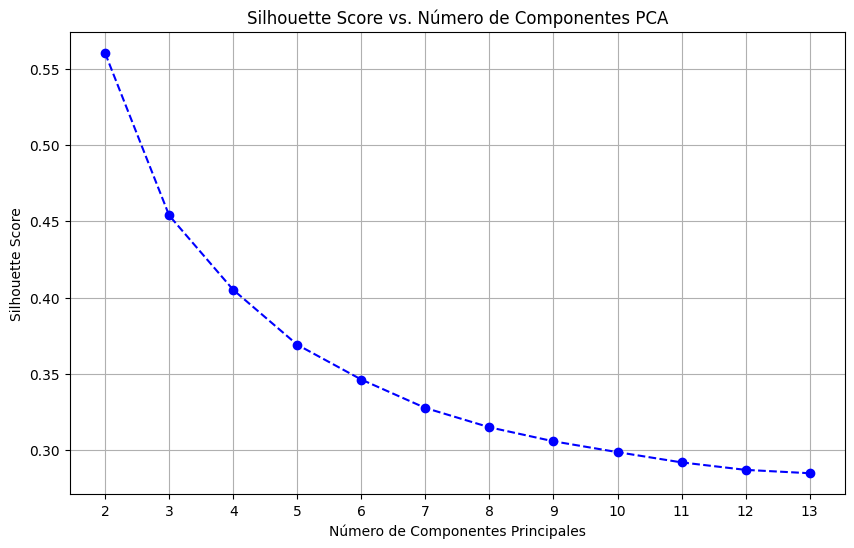

In [15]:
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# 2. Escalar los datos (esencial para PCA y K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Preparar el bucle para las componentes principales
silhouette_scores = []
component_range = range(2, 14)

for n_components in component_range:
    # Aplicar PCA con el número actual de componentes
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Aplicar K-Means con 3 clusters (el número de clases reales)
    kmeans = KMeans(n_clusters=3, random_state=42)
    y_kmeans = kmeans.fit_predict(X_pca)

    # Calcular el Silhouette Score y almacenarlo
    score = silhouette_score(X_pca, y_kmeans)
    silhouette_scores.append(score)

# 4. Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(component_range, silhouette_scores, marker='o', linestyle='--', color='b')
plt.title('Silhouette Score vs. Número de Componentes PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Silhouette Score')
plt.xticks(component_range)
plt.grid(True)
plt.show()